In [1]:
%cd /home/soda/rcappuzz/work/prepare-data-lakes

/home/soda/rcappuzz/work/prepare-data-lakes


In [36]:
%load_ext autoreload
%autoreload 2
import src.yago.utils as utils
import src.plotting.graph_utils as graph_utils
import src.plotting.plotting_utils as plotting_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import polars as pl
from pathlib import Path
import numpy as np
from tqdm import tqdm
sns.set_theme("paper", style="whitegrid")


In [4]:
yago_path = Path("/storage/store3/work/jstojano/yago3/")
facts1_path = Path(yago_path, "facts_parquet/yago_updated_2022_part1")
facts2_path = Path(yago_path, "facts_parquet/yago_updated_2022_part2")

## Reading yago triplets

`yagoTypes` contains the categories assigned to each subject. Subjects can have many categories.

`yagoFacts` contains categorical predicates (e.g. `hasChild`).

`yagoLiteralFacts` contains numerical predicates (e.g. `hasGDP`).

`yagoDateFacts` contains date facts. 

In [5]:
fname = "yagoTypes"
yagotypes_path = Path(facts1_path, f"{fname}.tsv.parquet")
yagotypes = utils.import_from_yago(yagotypes_path, engine="polars")


In [6]:
fname = "yagoFacts"
yagofacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagofacts = utils.import_from_yago(yagofacts_path, engine="polars")

In [7]:
fname = "yagoLiteralFacts"
yagoliteralfacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagoliteralfacts = utils.import_from_yago(yagoliteralfacts_path, engine="polars")


In [8]:
fname = "yagoDateFacts"
yagodatefacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagodatefacts = utils.import_from_yago(yagodatefacts_path, engine="polars")


## Some profiling

### Predicates

In [10]:
unique_facts = utils.find_unique_predicates(yagofacts)
print(unique_facts)

shape: (37, 1)
┌──────────────────┐
│ predicate        │
│ ---              │
│ str              │
╞══════════════════╡
│ <graduatedFrom>  │
│ <hasGender>      │
│ <hasNeighbor>    │
│ <directed>       │
│ …                │
│ <hasCapital>     │
│ <isConnectedTo>  │
│ <participatedIn> │
│ <livesIn>        │
└──────────────────┘


These predicates will be used as `attributes` in the wide-form version of YAGO. 

In [11]:
count_facts=utils.count_occurrences_by_columns(yagofacts, "predicate")
print(count_facts)

shape: (37, 2)
┌───────────────────────┬─────────┐
│ predicate             ┆ count   │
│ ---                   ┆ ---     │
│ str                   ┆ u32     │
╞═══════════════════════╪═════════╡
│ <isLocatedIn>         ┆ 3289399 │
│ <isCitizenOf>         ┆ 2390826 │
│ <hasGender>           ┆ 2016273 │
│ <isAffiliatedTo>      ┆ 1569882 │
│ …                     ┆ …       │
│ <hasOfficialLanguage> ┆ 989     │
│ <exports>             ┆ 714     │
│ <hasNeighbor>         ┆ 598     │
│ <imports>             ┆ 481     │
└───────────────────────┴─────────┘


Selecting only the top 10 facts to work with. 

In [12]:
top10facts = count_facts.head(10)

### Types

In [13]:
unique_types = utils.count_occurrences_by_columns(yagotypes, "cat_object")
# unique_types = unique_types.rename({"cat_object": "type"})

In [14]:
top_types=unique_types[:10]
print(top_types)

shape: (10, 2)
┌───────────────────────────────────┬─────────┐
│ cat_object                        ┆ count   │
│ ---                               ┆ ---     │
│ str                               ┆ u32     │
╞═══════════════════════════════════╪═════════╡
│ <wordnet_person_100007846>        ┆ 2034731 │
│ <wikicat_Living_people>           ┆ 1034138 │
│ <wordnet_administrative_district… ┆ 470161  │
│ <wordnet_officeholder_110371450>  ┆ 169553  │
│ …                                 ┆ …       │
│ <wordnet_artist_109812338>        ┆ 140435  │
│ <wordnet_season_115239579>        ┆ 106211  │
│ <wordnet_company_108058098>       ┆ 81358   │
│ <wordnet_event_100029378>         ┆ 79735   │
└───────────────────────────────────┴─────────┘


What is not immediately obvious here is that most of the top 10 types actually
co-occur: this means that most of the entities with type `person`" also have the 
type "`Living Person`".  Artists will also have both `person` and `artist` as 
their type. 


While looking at entity types, count the number of types each entity has and select the first for each of them. 

This is a naive approach: choosing the first type could return any of the types assigned to 
a subject. This is immediately evident from the example. 

In [15]:
first_type = (yagotypes.lazy().groupby(
    "subject"
).agg(
    [
        pl.first("cat_object"),
        pl.count()
    ]
).sort("count", descending=True).collect())

print(first_type.head(20))

shape: (20, 3)
┌───────────────────────────────────┬───────────────────────────────────┬───────┐
│ subject                           ┆ cat_object                        ┆ count │
│ ---                               ┆ ---                               ┆ ---   │
│ str                               ┆ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════════════════════════════════╪═══════╡
│ <First_Geneva_Convention>         ┆ <wikicat_Treaties_of_Indonesia>   ┆ 244   │
│ <Third_Geneva_Convention>         ┆ <wikicat_Treaties_of_the_Marshal… ┆ 243   │
│ <Second_Geneva_Convention>        ┆ <wikicat_Treaties_of_Indonesia>   ┆ 242   │
│ <Fourth_Geneva_Convention>        ┆ <wikicat_Treaties_of_the_Marshal… ┆ 241   │
│ …                                 ┆ …                                 ┆ …     │
│ <Protection_of_Diplomats_Convent… ┆ <wikicat_Treaties_of_Indonesia>   ┆ 218   │
│ <Treaty_on_the_Non-Proliferation… ┆ <wikicat_Treaties_of_the_Marshal… ┆ 217   │
│

Looking at the wiki page of the [First Geneva Convention](https://en.wikipedia.org/wiki/First_Geneva_Convention), it seems
that types have much smaller granularity than I had expected. I should probably focus only on the most frequent types 
and ignore others. 

Out of curiosity, let's plot the distribution of types and see what it looks like. 

(1, 1000000.0)

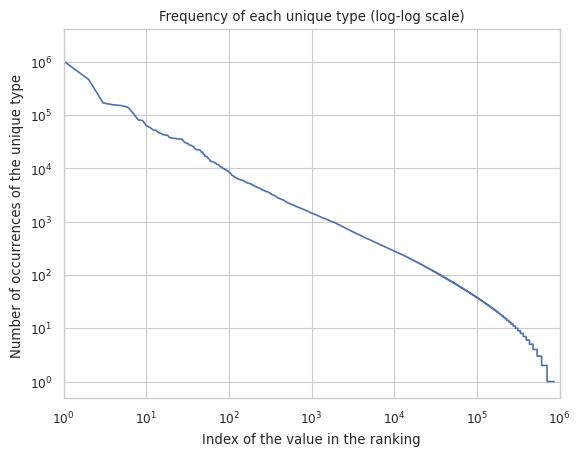

In [16]:
data=unique_types["count"]
ax = sns.lineplot(data=data)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Frequency of each unique type (log-log scale)")
ax.set_xlabel("Index of the value in the ranking")
ax.set_ylabel("Number of occurrences of the unique type ")
ax.set_xlim([1, 1e6])

Now I'm considering only the 10 most frequent types. 

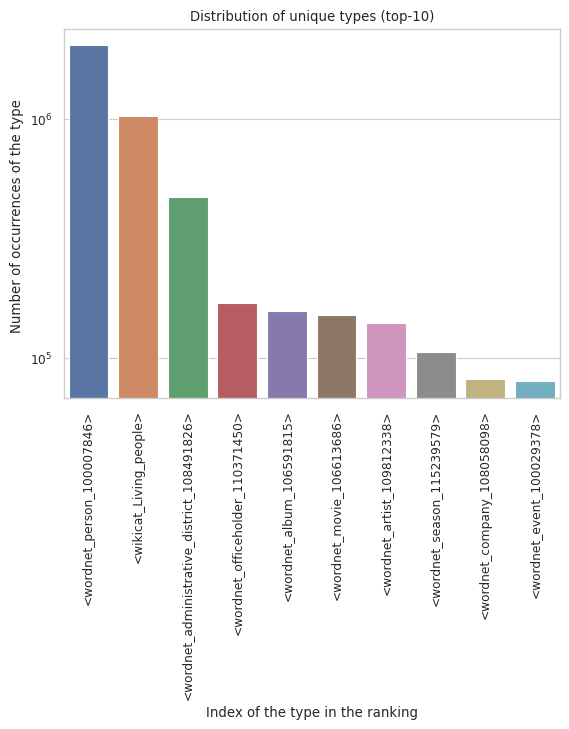

In [17]:
data=top_types["count"].to_pandas().reset_index()
ax = sns.barplot(data=data, x="index", y="count")
ax.set_yscale("log")
ax.set_title("Distribution of unique types (top-10)")
ax.set_xlabel("Index of the type in the ranking")
ax.set_ylabel("Number of occurrences of the type ")
_=ax.set_xticks(ticks=range(10),labels=top_types["cat_object"], rotation=90)

Below, I am saving in `subjects_with_most_freq_types` only the entities that have at least one of the types in `top_types`. 

This is again somewhat misleading, because some of those types are cooccurring. 

In [18]:
subjects_with_most_freq_types=(yagotypes.lazy().filter(
    pl.col("cat_object").is_in(top_types["cat_object"])
).groupby("subject").agg(
    pl.first()
).select(pl.col("subject")).collect())

To get a better sense of this, we should look at these cooccurrences in more detail. 

In [19]:
top_cooccurring_types=(yagotypes.lazy().filter(
    pl.col("cat_object").is_in(unique_types[:10]["cat_object"])
).join(
    yagotypes.lazy().filter(
    pl.col("cat_object").is_in(unique_types[:10]["cat_object"])
), on="subject",
).select(
    pl.col("cat_object").alias("type_left"),
    pl.col("cat_object_right").alias("type_right")
).groupby(
    ["type_left", "type_right"]
    ).agg(
    pl.count()
).sort("count", descending=True).collect())

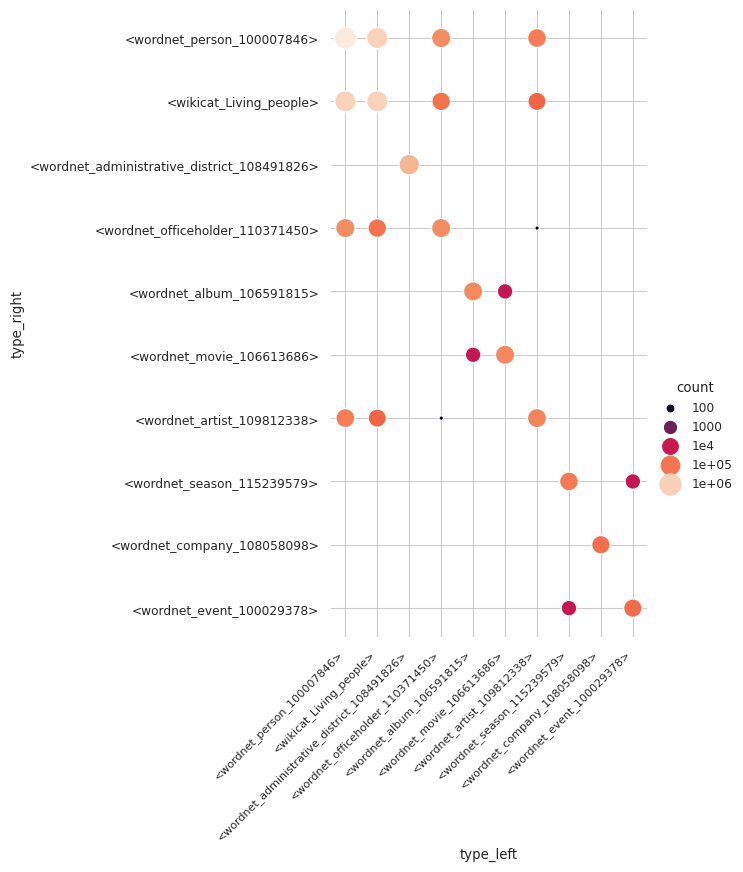

In [20]:
from matplotlib.colors import LogNorm
norm = LogNorm()
g = sns.relplot(
    data=top_cooccurring_types.to_pandas(),
    x="type_left",
    y="type_right",
    size="count",
    hue="count",
    hue_norm=norm,
    sizes=(10,250),
    size_norm=norm, 
    palette="rocket",
    height=7
    )
# g.set(xticks=np.arange(len(dd)), yticks=np.arange(len(dd)))
_=g.set_xticklabels(rotation=45, horizontalalignment='right', fontsize=8)
# _=g.set_yticklabels(list(dd.values()), horizontalalignment='right', fontsize=6)
sns.despine(left=True, bottom=True)

From the plot above, it's clear that a lot of the "top types" tend to co-occur, 
especially those that are relative to people. This is not too surprising, however
it is something that should be kept in mind for the next steps. 

### Numerical facts

In [21]:
unique_num_facts = utils.find_unique_predicates(yagoliteralfacts)
print(unique_num_facts)

shape: (28, 1)
┌───────────────────┐
│ predicate         │
│ ---               │
│ str               │
╞═══════════════════╡
│ <hasRevenue>      │
│ rdfs:comment      │
│ <hasInflation>    │
│ <hasUnemployment> │
│ …                 │
│ <hasTLD>          │
│ <hasExpenses>     │
│ <hasArea>         │
│ <hasExport>       │
└───────────────────┘


These predicates will be used as `attributes` in the wide-form version of YAGO. 

In [22]:
count_num_facts=utils.count_occurrences_by_columns(yagoliteralfacts, "predicate")
print(count_num_facts)

shape: (28, 2)
┌─────────────────────┬─────────┐
│ predicate           ┆ count   │
│ ---                 ┆ ---     │
│ str                 ┆ u32     │
╞═════════════════════╪═════════╡
│ <hasLatitude>       ┆ 1094024 │
│ <hasLongitude>      ┆ 1094024 │
│ <hasNumberOfPeople> ┆ 477278  │
│ <hasArea>           ┆ 233413  │
│ …                   ┆ …       │
│ <hasImport>         ┆ 195     │
│ <hasGini>           ┆ 171     │
│ <hasLanguageCode>   ┆ 156     │
│ rdfs:comment        ┆ 9       │
└─────────────────────┴─────────┘


### Date facts

In [23]:
unique_date_facts = utils.find_unique_predicates(yagodatefacts)
print(unique_date_facts)

shape: (6, 1)
┌──────────────────────┐
│ predicate            │
│ ---                  │
│ str                  │
╞══════════════════════╡
│ <wasDestroyedOnDate> │
│ <startedOnDate>      │
│ <wasBornOnDate>      │
│ <wasCreatedOnDate>   │
│ <diedOnDate>         │
│ <happenedOnDate>     │
└──────────────────────┘


These predicates will be used as `attributes` in the wide-form version of YAGO. 

In [24]:
count_date_facts=utils.count_occurrences_by_columns(yagodatefacts, "predicate")
print(count_date_facts)

shape: (6, 2)
┌──────────────────────┬─────────┐
│ predicate            ┆ count   │
│ ---                  ┆ ---     │
│ str                  ┆ u32     │
╞══════════════════════╪═════════╡
│ <wasCreatedOnDate>   ┆ 1749543 │
│ <wasBornOnDate>      ┆ 1682241 │
│ <diedOnDate>         ┆ 792352  │
│ <happenedOnDate>     ┆ 191445  │
│ <wasDestroyedOnDate> ┆ 163420  │
│ <startedOnDate>      ┆ 205     │
└──────────────────────┴─────────┘


## Combining all facts in one table

In [9]:
yagofacts_overall = pl.concat(
    [
        yagofacts,
        yagoliteralfacts,
        yagodatefacts
    ]
)

From now on, all operations will be carried out on `yagofacts_overall`. 

I'll first find the subjects that are connected to the largest number of triplets.
The same subject can be connected to many different objects through the same 
predicate. 

In [10]:
subject_count_sorted=(yagofacts_overall.lazy().groupby(
    "subject"
).agg(
    pl.count()
).sort(
    "count", descending=True
    ).collect())
print(subject_count_sorted.head())

shape: (5, 2)
┌──────────────────┬───────┐
│ subject          ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ <United_States>  ┆ 2975  │
│ <United_Kingdom> ┆ 1110  │
│ <Ilaiyaraaja>    ┆ 1000  │
│ <Nazi_Germany>   ┆ 959   │
│ <Microsoft>      ┆ 941   │
└──────────────────┴───────┘


As an example of the previous point, this is what happens if I count the number 
of occurrences of each predicate for the top entity. 

In [27]:
yagofacts_overall.lazy().filter(
    pl.col("subject") == subject_count_sorted[0, "subject"]
    ).groupby("predicate").agg(
        pl.count()
    ).sort("count", descending=True).collect()


predicate,count
str,u32
"""<participatedI…",2900
"""<owns>""",38
"""<hasMotto>""",6
"""<hasUnemployme…",6
"""<dealsWith>""",6
"""<hasNumberOfPe…",4
"""<hasInflation>…",2
"""<wasCreatedOnD…",1
"""<hasTLD>""",1


## Filter facts to select only types with the highest coverage

The objective of this section is to assign a single type to each subject. The 
chosen type is the type with the highest cardinality among those linked to the 
subject. 

A big issue that I am facing is the fact that relying only on the frequency of 
each type is misleading: by counting the number of types over the entirety of 
YAGO, some important types (e.g. country) are drowned out because there are very
few subjects that have that as a type, compared to, for example, people. 

To get around this, I am forcing the choice of a type by selecting only the top
type. This removes some important types (e.g. artist), but allows to select a 
wider set of entities compared to a blind selection of the top types. 

Note that I am selecting the top 10000 subjects (an arbitrary number) to bias the 
selection of the types to those that are most frequent in the subjects that have
larger influence on the rest. 

In [28]:
selected_types=subject_count_sorted.lazy().limit(
    10000 # Taking the top 10000 subjects
    ).join(
    yagotypes.lazy(), on="subject" # Joining on types table
    ).select( # Selecting only subject and type
    [
        pl.col("subject"),
        pl.col("cat_object")
    ]
).join( # Joining again on yagotypes to get the count of subjects by type
    yagotypes.groupby( # Grouping to get the count of subjects by type
        "cat_object"
    ).agg(
        pl.count() # Count of subjects by type
    ).lazy(), on="cat_object"
).sort( # Sorting to have the most frequent types at the start
    ["subject", "count"], descending=True
).groupby(["subject"]).agg( # Grouping by subject to have all types close to each other
    pl.first("cat_object").suffix("_first") # Selecting only the first entry from each group (i.e. the most frequent)
    ).groupby( # At this point the selection is done
        "cat_object_first" # Grouping by type to remove duplicates
        ).agg(
            pl.count() # counting the number of occurrences of each type
        ).sort( # Sorting by group (for convenience)
            "count", descending=True
            ).select(
                [
                    pl.col("cat_object_first").alias("type"),
                    pl.col("count")
                ],
            ).collect()
print(selected_types)

shape: (111, 2)
┌───────────────────────────────────┬───────┐
│ type                              ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ <wordnet_person_100007846>        ┆ 8724  │
│ <wordnet_country_108544813>       ┆ 314   │
│ <wordnet_company_108058098>       ┆ 276   │
│ <wordnet_artist_109812338>        ┆ 228   │
│ …                                 ┆ …     │
│ <wordnet_series_108457976>        ┆ 1     │
│ <wikicat_Organizations_establish… ┆ 1     │
│ <wikicat_20th-century_American_a… ┆ 1     │
│ <wikicat_Companies_based_in_San_… ┆ 1     │
└───────────────────────────────────┴───────┘


The previous step produced 111 types. Most of them appear only once, so I am 
clamping the selection to those that have been selected at least 10 times.

Text(0.5, 0, 'Ranking of the type')

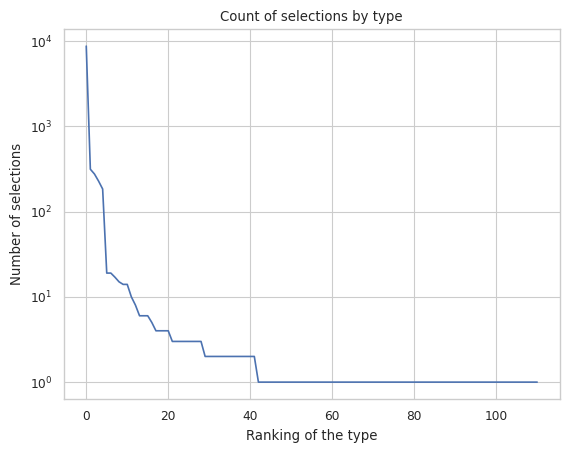

In [29]:
ax = sns.lineplot(data=selected_types.to_pandas(),x=np.arange(len(selected_types)), y="count")
ax.set_yscale("log")
ax.set_title("Count of selections by type")
ax.set_ylabel("Number of selections")
ax.set_xlabel("Ranking of the type")

In [30]:
top_selected = selected_types.filter(
    pl.col("count") > 10
)
print(top_selected)

shape: (11, 2)
┌───────────────────────────────────┬───────┐
│ type                              ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ <wordnet_person_100007846>        ┆ 8724  │
│ <wordnet_country_108544813>       ┆ 314   │
│ <wordnet_company_108058098>       ┆ 276   │
│ <wordnet_artist_109812338>        ┆ 228   │
│ …                                 ┆ …     │
│ <wordnet_organization_108008335>  ┆ 17    │
│ <wordnet_military_unit_108198398… ┆ 15    │
│ <wikicat_Musical_groups_from_Lon… ┆ 14    │
│ <wordnet_administrative_district… ┆ 14    │
└───────────────────────────────────┴───────┘


At this point, I can select the subjects whose type is among the selected ones, 
and use them for the next steps. 

In [31]:
subjects_in_selected_types = yagofacts_overall.lazy().join(top_selected.lazy().join(
    yagotypes.lazy(), left_on=["type"], right_on=["cat_object"]
).select(
    [
        pl.col("subject"),
        pl.col("type")
    ]
), left_on="subject", right_on="subject"
).collect()
print(subjects_in_selected_types)

shape: (17715452, 6)
┌─────────────────┬────────────────┬────────────────┬────────────────┬────────────┬────────────────┐
│ id              ┆ subject        ┆ predicate      ┆ cat_object     ┆ num_object ┆ type           │
│ ---             ┆ ---            ┆ ---            ┆ ---            ┆ ---        ┆ ---            │
│ str             ┆ str            ┆ str            ┆ str            ┆ f64        ┆ str            │
╞═════════════════╪════════════════╪════════════════╪════════════════╪════════════╪════════════════╡
│ <id_BOK!FvTDPu_ ┆ <Elizabeth_II> ┆ <isLeaderOf>   ┆ <Royal_Numisma ┆ null       ┆ <wordnet_perso │
│ H?S_1NVSTKkFbS> ┆                ┆                ┆ tic_Society>   ┆            ┆ n_100007846>   │
│ <id_gem0cCEu9e_ ┆ <Andrew_Harvey ┆ <isLeaderOf>   ┆ <New_Denmark,_ ┆ null       ┆ <wordnet_perso │
│ H?S_M9vQAWOiJO> ┆ _(politician)> ┆                ┆ New_Brunswick> ┆            ┆ n_100007846>   │
│ <id_GqUh9jFAN?_ ┆ <Andranik>     ┆ <isLeaderOf>   ┆ <Armenian_feda ┆

In [32]:
cooccurring_predicates_selected = utils.get_cooccurring_predicates(subjects_in_selected_types)
print(cooccurring_predicates_selected)

shape: (284015814, 2)
┌────────────────────┬────────────────────┐
│ predicate          ┆ predicate_right    │
│ ---                ┆ ---                │
│ str                ┆ str                │
╞════════════════════╪════════════════════╡
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ …                  ┆ …                  │
│ <wasCreatedOnDate> ┆ <hasGender>        │
│ <wasCreatedOnDate> ┆ <wasBornOnDate>    │
│ <wasCreatedOnDate> ┆ <diedOnDate>       │
│ <wasCreatedOnDate> ┆ <wasCreatedOnDate> │
└────────────────────┴────────────────────┘


In [33]:
count_cooccurring_predicates_selected = utils.get_count_cooccurring_predicates(cooccurring_predicates_selected)
display(count_cooccurring_predicates_selected.sort("count", descending=True))

predicate,predicate_right,count
str,str,u32
"""<created>""","""<created>""",34887301
"""<participatedI…","""<participatedI…",17586633
"""<wroteMusicFor…","""<wroteMusicFor…",15802899
"""<actedIn>""","""<actedIn>""",12942523
"""<isAffiliatedT…","""<isAffiliatedT…",11682231
"""<isAffiliatedT…","""<playsFor>""",9503133
"""<playsFor>""","""<isAffiliatedT…",9503133
"""<playsFor>""","""<playsFor>""",9206612
"""<isLocatedIn>""","""<isLocatedIn>""",5473835


## Filter facts to include only frequent types

In [34]:
subjects_in_toptypes=(yagofacts_overall.lazy().filter(
    pl.col("subject").is_in(subjects_with_most_freq_types["subject"])
).collect())

Here I am executing a self-join on `subjects_in_toptypes` to generate pairs of `predicate`s: these are the cases in 
which one `subject` has multiple `predicate`s, and these predicates co-occur. 

The reason why I am extracting these pairs is because this ensures that I can build tables by joining on the `subject`. 

In [35]:
cooccurring_predicates_toptypes= utils.get_cooccurring_predicates(subjects_in_toptypes)
print(cooccurring_predicates_toptypes)

shape: (204314730, 2)
┌────────────────────┬────────────────────┐
│ predicate          ┆ predicate_right    │
│ ---                ┆ ---                │
│ str                ┆ str                │
╞════════════════════╪════════════════════╡
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ <isLeaderOf>       ┆ <isLeaderOf>       │
│ …                  ┆ …                  │
│ <wasCreatedOnDate> ┆ <hasGender>        │
│ <wasCreatedOnDate> ┆ <wasBornOnDate>    │
│ <wasCreatedOnDate> ┆ <diedOnDate>       │
│ <wasCreatedOnDate> ┆ <wasCreatedOnDate> │
└────────────────────┴────────────────────┘


In [36]:
count_cooccurring_predicates_toptypes = utils.get_count_cooccurring_predicates(cooccurring_predicates_toptypes)
display(count_cooccurring_predicates_toptypes.sort("count", descending=True))

predicate,predicate_right,count
str,str,u32
"""<created>""","""<created>""",14961646
"""<actedIn>""","""<actedIn>""",12652804
"""<isAffiliatedT…","""<isAffiliatedT…",11679469
"""<playsFor>""","""<isAffiliatedT…",9502390
"""<isAffiliatedT…","""<playsFor>""",9502390
"""<playsFor>""","""<playsFor>""",9149626
"""<wroteMusicFor…","""<wroteMusicFor…",5564724
"""<isLocatedIn>""","""<isLocatedIn>""",5520635
"""<isCitizenOf>""","""<isCitizenOf>""",3650235


### Plotting co-occurring pairs

Finally, I am plotting the frequencies (y-axis has log-scale).

In [37]:
%load_ext autoreload
%autoreload 2
import src.yago.utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


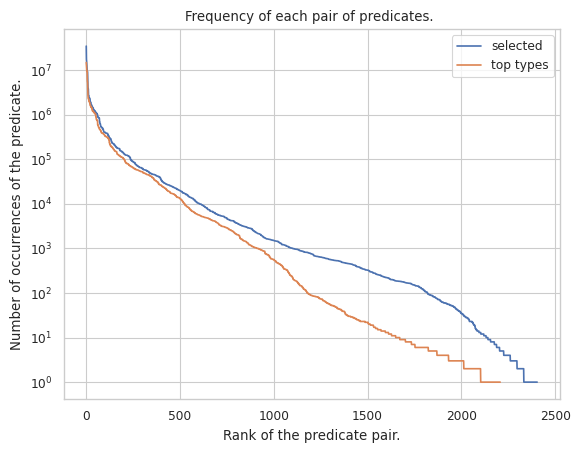

In [38]:
artists_array = []
fig, ax = plt.subplots()
labels = ["selected", "top types"]
for idx, count_df in enumerate([count_cooccurring_predicates_selected, count_cooccurring_predicates_toptypes]):
    utils.plot_predicate_frequency(count_df.to_pandas(), ax, label=labels[idx])

h, l = ax.get_legend_handles_labels()
plt.legend(h,l)

### Preparing a pairwise heatmap


<AxesSubplot: title={'center': 'Frequency of co-occurrence of predicate pairs in frequent values'}>

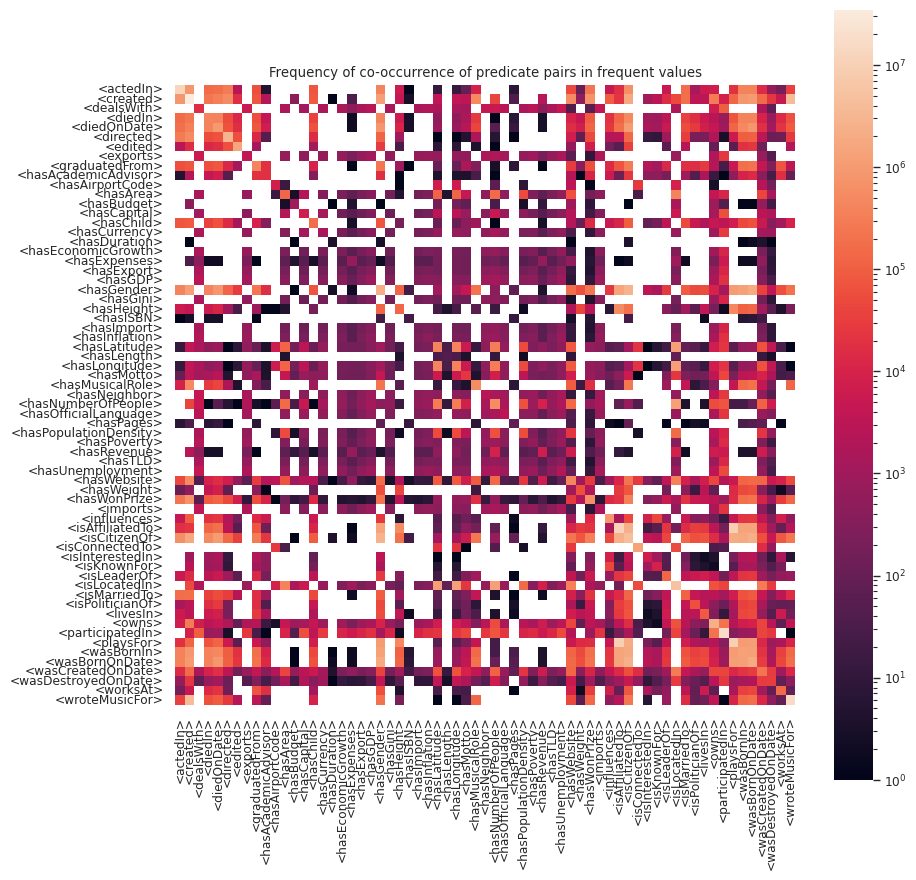

In [39]:
plotting_utils.plot_pairwise_heatmap(count_cooccurring_predicates_selected.to_pandas())

<AxesSubplot: title={'center': 'Frequency of co-occurrence of predicate pairs in frequent values'}>

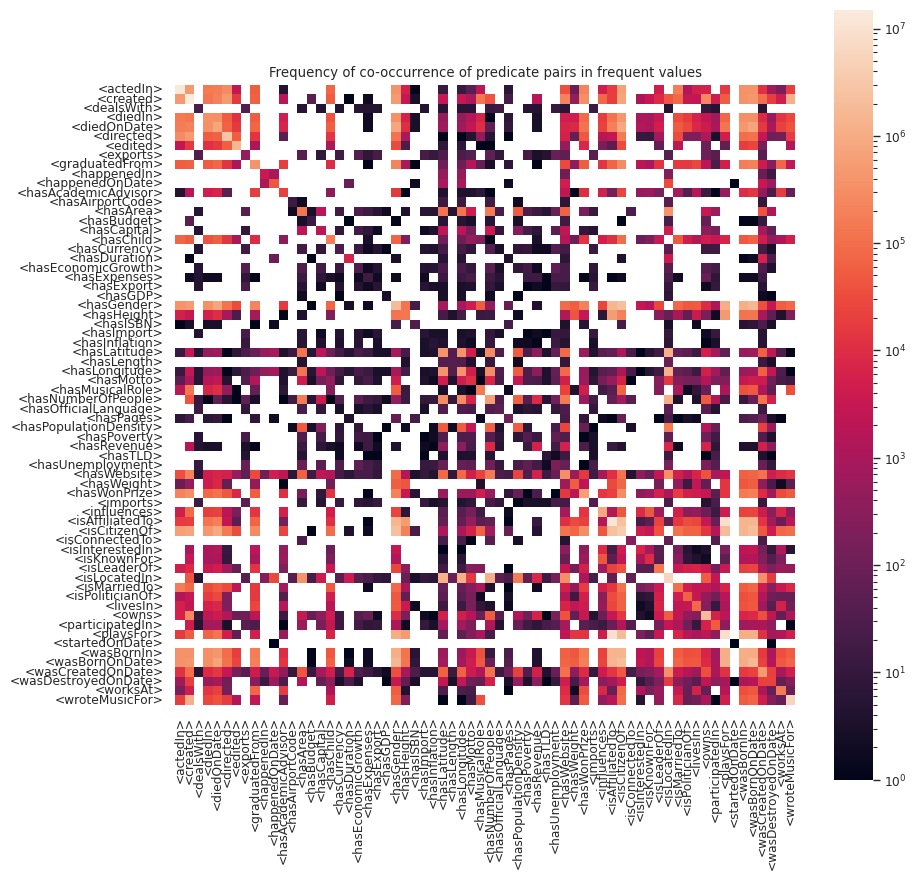

In [40]:
plotting_utils.plot_pairwise_heatmap(count_cooccurring_predicates_toptypes.to_pandas())

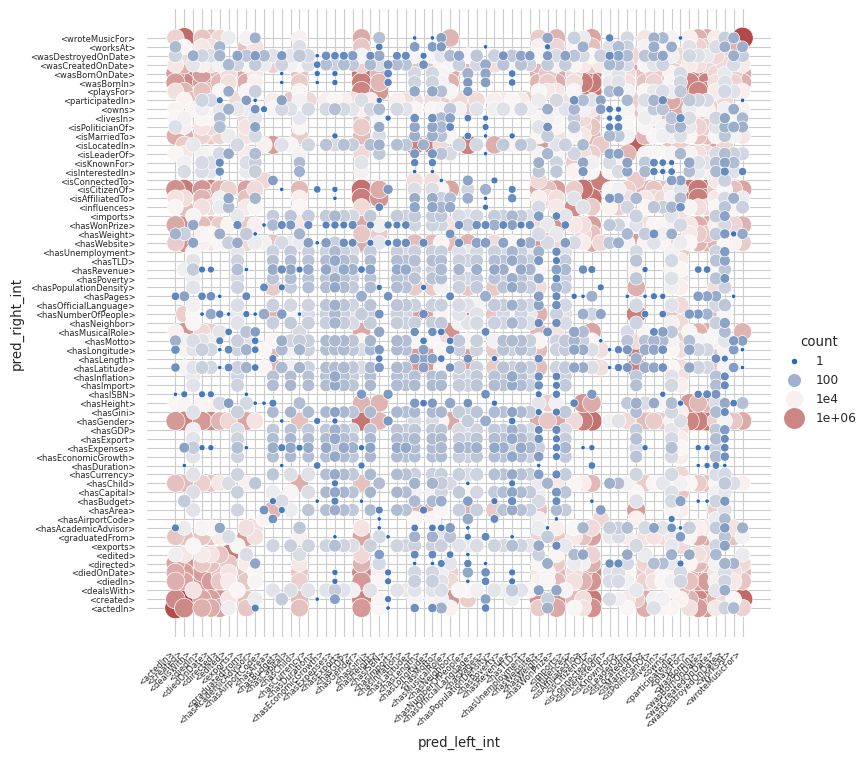

In [41]:
utils.plot_pairwise_relplot(count_cooccurring_predicates_selected.to_pandas())

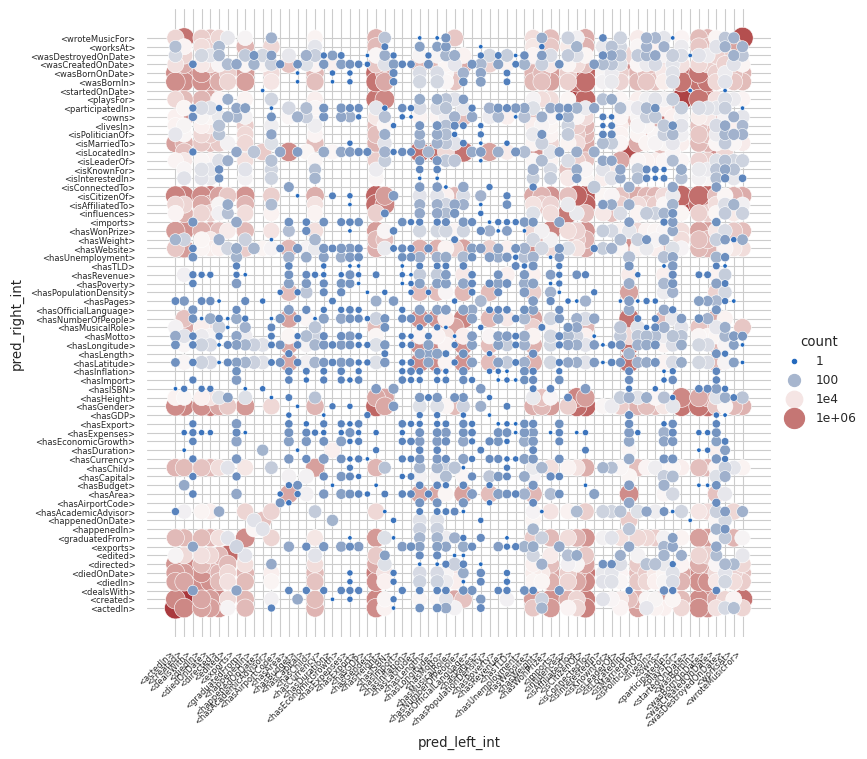

In [42]:
utils.plot_pairwise_relplot(count_cooccurring_predicates_toptypes.to_pandas())

In [43]:
selected_sorted = count_cooccurring_predicates_selected.sort(
    [
        "predicate",
        "predicate_right"
    ]
)

toptypes_sorted = count_cooccurring_predicates_toptypes.sort(
    [
        "predicate",
        "predicate_right"
    ]
)

In [44]:
def get_max_category(df):
    max_category = (
        df[["pred_left_int", "pred_right_int"]]
        .max()
        .max()
    )
    return max_category

In [45]:
selected_sorted = utils.get_numerical_coordinates(selected_sorted.to_pandas())
toptypes_sorted = utils.get_numerical_coordinates(toptypes_sorted.to_pandas())

In [46]:
max_category = max(get_max_category(selected_sorted), get_max_category(toptypes_sorted))

In [47]:
def get_count_matrix(df, size):

    count_matrix = np.zeros((size+1, size+1))
    count_matrix[df["pred_left_int"], df["pred_right_int"]] = df["count"]
    return count_matrix

In [48]:
sel_mat = get_count_matrix(selected_sorted, max_category)
typ_mat = get_count_matrix(toptypes_sorted, max_category)

In [49]:
(sel_mat>0).astype(int)

array([[1, 1, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<AxesSubplot: >

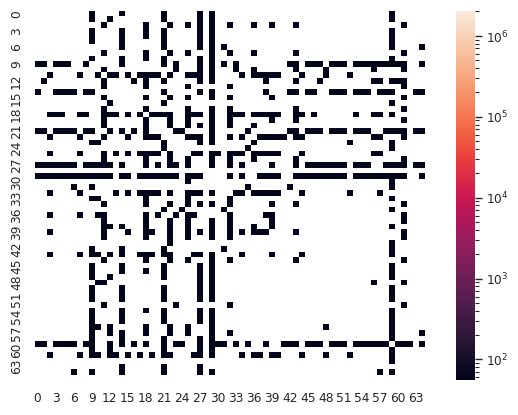

In [50]:
sns.heatmap(data=((sel_mat>0).astype(int) - (typ_mat>0).astype(int)), norm=norm)

<AxesSubplot: >

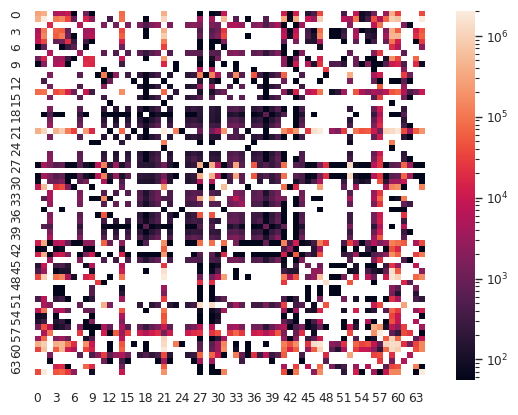

In [51]:
sns.heatmap(data=sel_mat - typ_mat, norm=norm)

# Plotting relations as a graph

In [52]:
G = nx.Graph()

### Join predicates with types

In [53]:
top_types

cat_object,count
str,u32
"""<wordnet_perso…",2034731
"""<wikicat_Livin…",1034138
"""<wordnet_admin…",470161
"""<wordnet_offic…",169553
"""<wordnet_album…",156553
"""<wordnet_movie…",151678
"""<wordnet_artis…",140435
"""<wordnet_seaso…",106211
"""<wordnet_compa…",81358


In [54]:
types_predicates_selected = utils.join_types_predicates(yagotypes, yagofacts_overall, types_subset=top_selected)
types_predicates_toptypes = utils.join_types_predicates(yagotypes, yagofacts_overall, types_subset=top_types.rename({"cat_object": "type"}))

### Creating graph viz

In [80]:
G = nx.Graph()
for edge in types_predicates_selected.iter_rows():
    left, right, weight = edge
    G.add_edge(left,right, weight=weight)
left, right = types_predicates_selected["type"], types_predicates_selected["predicate"]
utils.plot_graph(G, left, right)

In [56]:
G = nx.Graph()
for edge in types_predicates_toptypes.iter_rows():
    left, right, weight = edge
    G.add_edge(left,right, weight=weight)
left, right = types_predicates_toptypes["type"], types_predicates_toptypes["predicate"]
utils.plot_graph(G, left, right)

# Building tables

## Top 10 types

The tables built here are based on the top 10 types by number of subjects, i.e. the types that are connected to the largest
number of subjects in `yagotypes`. I realized later that this is a misleading set because it excludes some very important
subjects (e.g. countries are not includes because they have a very small number of subjects in comparison to other types).

There is also the problem that `Living_Person` and `person` are both present. 

In [60]:
groups = yagotypes.lazy().join(
    top_types.lazy().select(pl.col("cat_object")),
    on="cat_object",
    how="inner"
).groupby(
    pl.col("cat_object")
).all().select(
    [
        pl.col("cat_object"), 
        pl.col("subject")
    ]
    ).collect()

In [ ]:
tabs_by_type = {}
for tup in groups.iter_rows():
    type_str, values = tup
    tab = pl.DataFrame(
        {
        "type": [type_str]*len(values),
        "subject": values
        },
    )
    tabs_by_type[type_str]=tab
    print(type_str)

<wordnet_company_108058098>
<wordnet_album_106591815>
<wordnet_season_115239579>
<wikicat_Living_people>
<wordnet_event_100029378>
<wordnet_administrative_district_108491826>
<wordnet_officeholder_110371450>
<wordnet_person_100007846>
<wordnet_artist_109812338>
<wordnet_movie_106613686>


In [58]:
tabs_by_type[type_str]

NameError: name 'tabs_by_type' is not defined

In [59]:
groups_predicates = yagofacts.groupby("predicate")

## More reasonable approach

With this approach I am starting from the most frequent subjects, selecting only the most frequent type among all the 
types a subject is connected to, then keeping only the first 20 most frequent types. 

This should give a better (more representative, more general) representation of the data. 

In [61]:
type_groups = (yagotypes.lazy().join(
    selected_types.head(10).lazy(), 
    left_on="cat_object", right_on="type"
    ).select(
        [
            pl.col("subject"),
            pl.col("cat_object")
        ]
    ).groupby("cat_object").all().select(
        [
            pl.col("cat_object"),
            pl.col("subject"),
        ]
        ).collect())

In [63]:
cooccurring_predicates=(subjects_in_toptypes.lazy().join(
    subjects_in_toptypes.lazy(), left_on="subject",
    right_on="subject", how="left"
).select(
    [
        pl.col("predicate"),
        pl.col("predicate_right")
    ]
).groupby("predicate_right").agg(
    pl.first("predicate")
).collect())

In [65]:
tabs_by_type = {}
for tup in type_groups.iter_rows():
    type_str, values = tup
    tab = pl.DataFrame(
        {
        "type": [type_str]*len(values),
        "subject": values
        },
    )
    tabs_by_type[type_str]=tab
    print(type_str)

<wordnet_government_108050678>
<wordnet_country_108544813>
<wordnet_company_108058098>
<wikicat_Musical_groups_from_London>
<wordnet_organization_108008335>
<wordnet_airport_102692232>
<wordnet_artist_109812338>
<wordnet_person_100007846>
<wordnet_agency_108337324>
<wordnet_military_unit_108198398>


In [66]:
tab

type,subject
str,str
"""<wordnet_milit…","""<I_Royal_Bavar…"
"""<wordnet_milit…","""<Glasgow_Briga…"
"""<wordnet_milit…","""<147th_Aero_Sq…"
"""<wordnet_milit…","""<Croatian_Defe…"
"""<wordnet_milit…","""<fr/522e_régim…"
"""<wordnet_milit…","""<41_Service_Ba…"
"""<wordnet_milit…","""<164th_Airlift…"
"""<wordnet_milit…","""<Anhui_clique>…"
"""<wordnet_milit…","""<No._692_Squad…"


In [67]:
for type_str, tab in tabs_by_type.items():
    print(type_str, len(tab))

<wordnet_government_108050678> 227
<wordnet_country_108544813> 17080
<wordnet_company_108058098> 81358
<wikicat_Musical_groups_from_London> 491
<wordnet_organization_108008335> 26142
<wordnet_airport_102692232> 15528
<wordnet_artist_109812338> 140435
<wordnet_person_100007846> 2034731
<wordnet_agency_108337324> 6831
<wordnet_military_unit_108198398> 27105


In [68]:
def convert_df(df: pl.DataFrame, predicate):
    return df.select(
        pl.col("subject"),
        pl.col("cat_object").alias(predicate)
    ).lazy()

### Saving tables

In [81]:
dest_path = Path("data/yago3-dl/seltab")

In [82]:
list(tabs_by_type.keys())

['<wordnet_government_108050678>',
 '<wordnet_country_108544813>',
 '<wordnet_company_108058098>',
 '<wikicat_Musical_groups_from_London>',
 '<wordnet_organization_108008335>',
 '<wordnet_airport_102692232>',
 '<wordnet_artist_109812338>',
 '<wordnet_person_100007846>',
 '<wordnet_agency_108337324>',
 '<wordnet_military_unit_108198398>']

In [83]:
G.nodes

NodeView(('<wordnet_person_100007846>', '<hasGender>', '<isCitizenOf>', '<wasBornOnDate>', '<wasBornIn>', '<diedOnDate>', '<wordnet_administrative_district_108491826>', '<isLocatedIn>', '<isAffiliatedTo>', '<hasLatitude>', '<hasLongitude>', '<diedIn>', '<hasNumberOfPeople>', '<playsFor>', '<graduatedFrom>', '<hasArea>', '<hasHeight>', '<wordnet_artist_109812338>', '<created>', '<hasWonPrize>', '<hasWebsite>', '<isMarriedTo>', '<wordnet_company_108058098>', '<wasCreatedOnDate>', '<actedIn>', '<hasWeight>', '<hasPopulationDensity>', '<hasChild>', '<isPoliticianOf>', '<livesIn>', '<worksAt>', '<hasMusicalRole>', '<directed>', '<wordnet_military_unit_108198398>', '<isLeaderOf>', '<wordnet_organization_108008335>', '<hasAcademicAdvisor>', '<wordnet_airport_102692232>', '<wordnet_country_108544813>', '<wasDestroyedOnDate>', '<wroteMusicFor>', '<hasAirportCode>', '<influences>', '<owns>', '<hasRevenue>', '<wordnet_agency_108337324>', '<hasMotto>', '<isConnectedTo>', '<hasCapital>', '<isIntere

In [84]:
full_tables_by_type = {}
for type_str, tab in tqdm(tabs_by_type.items(), total=len(tabs_by_type)):
    new_tab = tab.clone()
    tqdm.write(type_str)
    for pred_name, pred_group in yagofacts.groupby("predicate"):
        if pred_name in G.neighbors(type_str) and len(new_tab.columns) < 15:
        # if pred_name in G.neighbors(type_str) and pred_name in count_facts[:15]["predicate"]:
            transformed_tab = convert_df(pred_group, pred_name)
            new_tab= new_tab.lazy().join(
                transformed_tab.lazy(),
                on="subject",
                how="left"
            )
    fname = f"yago_seltab_{type_str}.parquet"
    new_tab.collect().write_parquet(Path(dest_path, fname))
    # full_tables_by_type[type_str].collect()

  0%|          | 0/10 [00:00<?, ?it/s]

<wordnet_government_108050678>


 10%|█         | 1/10 [00:01<00:14,  1.62s/it]

<wordnet_country_108544813>


 20%|██        | 2/10 [00:18<01:25, 10.68s/it]

<wordnet_company_108058098>


 30%|███       | 3/10 [00:20<00:46,  6.71s/it]

<wikicat_Musical_groups_from_London>


 40%|████      | 4/10 [00:22<00:28,  4.69s/it]

<wordnet_organization_108008335>


 50%|█████     | 5/10 [00:23<00:17,  3.60s/it]

<wordnet_airport_102692232>


 60%|██████    | 6/10 [00:25<00:11,  2.93s/it]

<wordnet_artist_109812338>


 70%|███████   | 7/10 [00:27<00:08,  2.67s/it]

<wordnet_person_100007846>


 80%|████████  | 8/10 [00:41<00:12,  6.18s/it]

<wordnet_agency_108337324>


 90%|█████████ | 9/10 [00:42<00:04,  4.74s/it]

<wordnet_military_unit_108198398>


100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


In [77]:
type_str = "<wordnet_country_108544813>"
tab=tabs_by_type[type_str]


new_tab = tab.clone()
tqdm.write(type_str)
for pred_name, pred_group in yagofacts.groupby("predicate"):
    if pred_name in G.neighbors(type_str) and len(new_tab.columns) < 15:
    # if pred_name in G.neighbors(type_str) and pred_name in count_facts[:15]["predicate"]:
        transformed_tab = convert_df(pred_group, pred_name)
        new_tab= new_tab.lazy().join(
            transformed_tab.lazy(),
            on="subject",
            how="left"
        )
# fname = f"yago_seltab_{type_str}.parquet"
new_tab.collect()


<wordnet_country_108544813>


type,subject,,,,,,,,,,,,
str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""<wordnet_count…","""<Congo_at_the_…",null,null,null,null,null,null,null,null,null,null,null,null
"""<wordnet_count…","""<Grenada_at_th…",null,null,null,null,"""<http://www.gr…",null,null,null,null,null,"""<Seoul>""",null
"""<wordnet_count…","""<Algeria_at_th…",null,null,null,null,null,null,null,null,null,null,null,null
"""<wordnet_count…","""<Mali_at_the_2…",null,null,null,null,null,null,null,null,null,null,"""<Barcelona>""",null
"""<wordnet_count…","""<Mali_at_the_2…",null,null,null,null,null,null,null,null,null,null,"""<Spain>""",null
"""<wordnet_count…","""<South_Africa_…",null,null,null,null,null,null,null,null,null,null,"""<Osaka>""",null
"""<wordnet_count…","""<Guyana_at_the…",null,null,null,null,null,null,null,null,null,null,"""<Rio_de_Janeir…",null
"""<wordnet_count…","""<First_Empire_…",null,null,null,"""<Haitian_livre…",null,"""<Port-au-Princ…","""<1804_Haiti_ma…",null,null,null,"""<Caribbean>""",null
"""<wordnet_count…","""<First_Empire_…",null,null,null,"""<Haitian_livre…",null,"""<Port-au-Princ…","""<Siege_of_Sant…",null,null,null,"""<Caribbean>""",null


In [79]:
print(new_tab.collect().describe())

shape: (7, 15)
┌───────────┬───────────┬───────────┬────────────┬───┬──────────┬─────────┬────────────┬───────────┐
│ describe  ┆ type      ┆ subject   ┆ <hasOffici ┆ … ┆ <owns>   ┆ <import ┆ <isLocated ┆ <dealsWit │
│ ---       ┆ ---       ┆ ---       ┆ alLanguage ┆   ┆ ---      ┆ s>      ┆ In>        ┆ h>        │
│ str       ┆ str       ┆ str       ┆ >          ┆   ┆ str      ┆ ---     ┆ ---        ┆ ---       │
│           ┆           ┆           ┆ ---        ┆   ┆          ┆ str     ┆ str        ┆ str       │
│           ┆           ┆           ┆ str        ┆   ┆          ┆         ┆            ┆           │
╞═══════════╪═══════════╪═══════════╪════════════╪═══╪══════════╪═════════╪════════════╪═══════════╡
│ count     ┆ 30816436  ┆ 30816436  ┆ 30816436   ┆ … ┆ 30816436 ┆ 3081643 ┆ 30816436   ┆ 30816436  │
│           ┆           ┆           ┆            ┆   ┆          ┆ 6       ┆            ┆           │
│ null_coun ┆ 0         ┆ 0         ┆ 5483739    ┆ … ┆ 368341   ┆ 4197147 ┆ 

### Saving tables

In [ ]:
dest_path = Path("data/yago3-dl/typetab")

In [ ]:
for type_str, tab in full_tables_by_type.items():
    fname = f"yago_typetab_{type_str}.parquet"
    tab.collect().write_parquet(Path(dest_path, fname))

## Wordnet categories

Rather than relying on arbitrary heuristics like I am in the steps above, here I will be relying exclusively on the 
wordnet categories, since they appear to be less "random" than the wikicat categories. This will be another version of the
data lake. 

In [17]:
wordnet_categories = yagotypes.lazy().filter(
    pl.col("cat_object").str.starts_with("<wordnet_")
).select(
    pl.col("cat_object").unique()
).collect()

In [23]:
top_k = 20
top_wordnet = yagotypes.lazy().filter(
    pl.col("cat_object").is_in(wordnet_categories["cat_object"])
).groupby("cat_object").count().top_k(k=top_k, by="count").collect()

In [25]:
utils.get_subjects_in_wordnet_categories(yagofacts_overall, yagotypes)

ColumnNotFoundError: type

Error originated just after this operation:
DF ["cat_object", "count"]; PROJECT */2 COLUMNS; SELECTION: "None"

Error originated just after this operation:
ErrorStateSync(Mutex { data: AlreadyEncountered { prev_err_msg: "ColumnNotFound(ErrString(\"type\\n\\nError originated just after this operation:\\nDF [\\\"cat_object\\\", \\\"count\\\"]; PROJECT */2 COLUMNS; SELECTION: \\\"None\\\"\"))" }, poisoned: false, .. })
DF ["cat_object", "count"]; PROJECT */2 COLUMNS; SELECTION: "None"

Error originated just after this operation:
DF ["id", "subject", "predicate", "cat_object"]; PROJECT */5 COLUMNS; SELECTION: "None"

In [26]:
def get_subjects_in_wordnet_categories(
    yagofacts,
    yagotypes, top_k=20
):
    wordnet_categories = yagotypes.lazy().filter(
        pl.col("cat_object").str.starts_with("<wordnet_")
    ).select(
        pl.col("cat_object").unique()
    ).collect()
    
    top_wordnet = yagotypes.lazy().filter(
        pl.col("cat_object").is_in(wordnet_categories["cat_object"])
    ).groupby("cat_object").count().top_k(k=top_k, by="count").collect()

    subjects = (
        yagofacts.lazy().join(
            top_wordnet.lazy()
            .join(yagotypes.lazy(), left_on=["type"], right_on=["cat_object"])
            .select([pl.col("subject"), pl.col("type")]),
            left_on="subject",
            right_on="subject",
        )
        .collect()
    )
    return subjects, top_wordnet


In [42]:
yagotypes.rename({"cat_object":"type"})

id,subject,predicate,type,num_object
str,str,str,str,f64
null,"""<yagoTheme_typ…","""<hasGloss>""","""This file is p…",null
"""<id_j?RsaAy9FT…","""<Stathmopoda_a…","""rdf:type""","""<wikicat_Moths…",null
"""<id_j?RsaAy9FT…","""<Stathmopoda_a…","""rdf:type""","""<wikicat_Moths…",null
"""<id_IDwmgVA9s0…","""<1908_St._Loui…","""rdf:type""","""<wikicat_St._L…",null
"""<id_mUhCPivGvE…","""<A1086_road>""","""rdf:type""","""<wikicat_Roads…",null
"""<id_mUhCPivGvE…","""<A1086_road>""","""rdf:type""","""<wordnet_road_…",null
"""<id_LDRCnqcknu…","""<Pluralist_Dem…","""rdf:type""","""<wikicat_Polit…",null
"""<id_LDRCnqcknu…","""<Pluralist_Dem…","""rdf:type""","""<wordnet_party…",null
"""<id_QCt3Vm7wgc…","""<Saccobolus_gl…","""rdf:type""","""<wikicat_Fungi…",null


In [41]:
get_subjects_in_wordnet_categories(yagofacts_overall, yagotypes)

ColumnNotFoundError: type

Error originated just after this operation:
DF ["cat_object", "count"]; PROJECT */2 COLUMNS; SELECTION: "None"

Error originated just after this operation:
ErrorStateSync(Mutex { data: AlreadyEncountered { prev_err_msg: "ColumnNotFound(ErrString(\"type\\n\\nError originated just after this operation:\\nDF [\\\"cat_object\\\", \\\"count\\\"]; PROJECT */2 COLUMNS; SELECTION: \\\"None\\\"\"))" }, poisoned: false, .. })
DF ["cat_object", "count"]; PROJECT */2 COLUMNS; SELECTION: "None"

Error originated just after this operation:
DF ["id", "subject", "predicate", "cat_object"]; PROJECT */5 COLUMNS; SELECTION: "None"

In [32]:
wordnet_categories = yagotypes.lazy().filter(
    pl.col("cat_object").str.starts_with("<wordnet_")
).select(
    pl.col("cat_object").unique()
).collect()

top_wordnet = yagotypes.lazy().filter(
    pl.col("cat_object").is_in(wordnet_categories["cat_object"])
).rename({"cat_object":"type"}).groupby("type").count().top_k(k=top_k, by="count").collect()



In [33]:
top_wordnet

type,count
str,u32
"""<wordnet_perso…",2034731
"""<wordnet_admin…",470161
"""<wordnet_offic…",169553
"""<wordnet_album…",156553
"""<wordnet_movie…",151678
"""<wordnet_artis…",140435
"""<wordnet_seaso…",106211
"""<wordnet_compa…",81358
"""<wordnet_event…",79735


In [34]:
subjects = (
    yagofacts.lazy().join(
        top_wordnet.lazy()
        .join(
                yagotypes.lazy(), left_on=["type"], right_on=["cat_object"]
            )
        .select([pl.col("subject"), pl.col("type")]),
        left_on="subject",
        right_on="subject",
    )
    .collect()
)


In [38]:
wordnet_categories = yagotypes.lazy().filter(
    pl.col("cat_object").str.starts_with("<wordnet_")
).select(
    pl.col("cat_object").unique()
).collect()

top_wordnet = yagotypes.lazy().filter(
    pl.col("cat_object").is_in(wordnet_categories["cat_object"])
).rename({"cat_object":"type"}).groupby("type").count().top_k(k=top_k, by="count").collect()

subjects = (
    yagofacts.lazy().join(
        top_wordnet.lazy()
        .join(yagotypes.lazy(), left_on=["type"], right_on=["cat_object"])
        .select([pl.col("subject"), pl.col("type")]),
        left_on="subject",
        right_on="subject",
    )
    .collect()
)
